# Introvert-Extrovert Classification

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv("data/train.csv")
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [27]:
X = df.drop(["Personality"], axis=1)
y = df["Personality"]

In [24]:
df["Stage_fear"] = df["Stage_fear"].replace({"No":0, "Yes":1})
df["Drained_after_socializing"] = df["Drained_after_socializing"].replace({"No": 0, "Yes": 1})

In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
x_filled = imputer.fit_transform(X)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  float64
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  float64
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 1.3+ MB


In [35]:
from sklearn.cluster import KMeans

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=33, init="k-means++")
    kmeans.fit(x_filled)
    inertia.append(kmeans.inertia_)

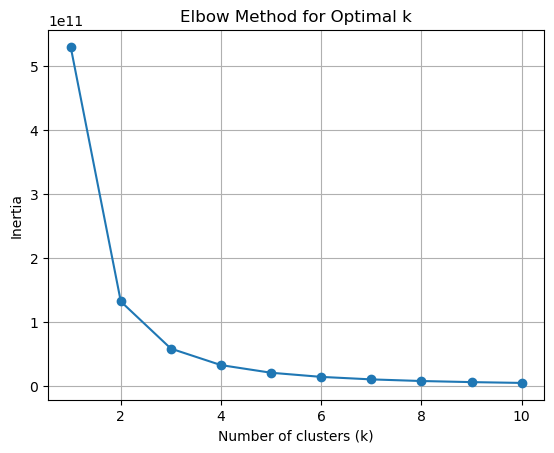

In [49]:
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()